In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 13 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Michael Steinbach <stei0062@umn.edu>

With contributions totally ripped off from Dima Duev (CIT), Lex Friedman (MIT), and François Chollet (Google)



# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning

<img src='img/dl11.png'>

<img src='img/dl12.png'>

# More: Recipe / Practical advice from one of DL godfathers Andrej Karpathy

Highly recommended: [Andrej Karpathy's blog post](http://karpathy.github.io/2019/04/25/recipe/)

- Neural net training is a leaky abstraction

```bash
>>> your_data = # plug your awesome dataset here
>>> model = SuperCrossValidator(SuperDuper.fit, your_data, ResNet50, SGDOptimizer)
# conquer world here
```

- Neural net training fails silently

Lots of ways to screw things up -> many paths to pain and suffering


## Overfitting

To find a good model takes two stages: first get a model large enough that it can overfit (i.e. focus on training loss) and then regularize it appropriately (give up some training loss to improve the validation loss).

### Tips & tricks for this stage:

- **picking the model**. To reach a good training loss you’ll want to choose an appropriate architecture for the data. When it comes to choosing this my #1 advice is: Don’t be a hero. I’ve seen a lot of people who are eager to get crazy and creative in stacking up the lego blocks of the neural net toolbox in various exotic architectures that make sense to them. Resist this temptation strongly in the early stages of your project. I always advise people to simply find the most related paper and copy paste their simplest architecture that achieves good performance. E.g. if you are classifying images don’t be a hero and just copy paste a ResNet-50 for your first run. You’re allowed to do something more custom later and beat this.
- **adam is safe**. In the early stages of setting baselines I like to use Adam with a learning rate of 3e-4. In my experience Adam is much more forgiving to hyperparameters, including a bad learning rate. For ConvNets a well-tuned SGD will almost always slightly outperform Adam, but the optimal learning rate region is much more narrow and problem-specific. (Note: If you are using RNNs and related sequence models it is more common to use Adam. At the initial stage of your project, again, don’t be a hero and follow whatever the most related papers do.)
- **complexify only one at a time**. If you have multiple signals to plug into your classifier I would advise that you plug them in one by one and every time ensure that you get a performance boost you’d expect. Don’t throw the kitchen sink at your model at the start. There are other ways of building up complexity - e.g. you can try to plug in smaller images first and make them bigger later, etc.
- **do not trust learning rate decay defaults**. If you are re-purposing code from some other domain always be very careful with learning rate decay. Not only would you want to use different decay schedules for different problems, but - even worse - in a typical implementation the schedule will be based current epoch number, which can vary widely simply depending on the size of your dataset. E.g. ImageNet would decay by 10 on epoch 30. If you’re not training ImageNet then you almost certainly do not want this. If you’re not careful your code could secretely be driving your learning rate to zero too early, not allowing your model to converge. In my own work I always disable learning rate decays entirely (I use a constant LR) and tune this all the way at the very end.


## Regularize

Now to regularize the model and gain some validation accuracy by giving up some of the training accuracy.

### Tips & tricks for this stage:

- **get more data. First**, the by far best and preferred way to regularize a model in any practical setting is to add more real training data. It is a very common mistake to spend a lot engineering cycles trying to squeeze juice out of a small dataset when you could instead be collecting more data. As far as I’m aware adding more data is pretty much the only guaranteed way to monotonically improve the performance of a well-configured neural network almost indefinitely. The other would be ensembles (if you can afford them), but that tops out after ~5 models.
- **data augment**. The next best thing to real data is half-fake data - try out more aggressive data augmentation.
- **creative augmentation**. If half-fake data doesn’t do it, fake data may also do something. People are finding creative ways of expanding datasets; For example, domain randomization, use of simulation, clever hybrids such as inserting (potentially simulated) data into scenes, or even GANs.
- **pretrain**. It rarely ever hurts to use a pretrained network if you can, even if you have enough data.
- **stick with supervised learning**. Do not get over-excited about unsupervised pretraining. Unlike what that blog post from 2008 tells you, as far as I know, no version of it has reported strong results in modern computer vision (though NLP seems to be doing pretty well with BERT and friends these days, quite likely owing to the more deliberate nature of text, and a higher signal to noise ratio).
- **smaller input dimensionality**. Remove features that may contain spurious signal. Any added spurious input is just another opportunity to overfit if your dataset is small. Similarly, if low-level details don’t matter much try to input a smaller image.
- **smaller model size**. In many cases you can use domain knowledge constraints on the network to decrease its size. As an example, it used to be trendy to use Fully Connected layers at the top of backbones for ImageNet but these have since been replaced with simple average pooling, eliminating a ton of parameters in the process.
- **decrease the batch size**. Due to the normalization inside batch norm smaller batch sizes somewhat correspond to stronger regularization. This is because the batch empirical mean/std are more approximate versions of the full mean/std so the scale & offset “wiggles” your batch around more.
- **drop**. Add dropout. Use dropout2d (spatial dropout) for ConvNets. Use this sparingly/carefully because dropout does not seem to play nice with batch normalization.
- **weight decay**. Increase the weight decay penalty.
- **early stopping**. Stop training based on your measured validation loss to catch your model just as it’s about to overfit.
- **try a larger model**. I mention this last and only after early stopping but I’ve found a few times in the past that larger models will of course overfit much more eventually, but their “early stopped” performance can often be much better than that of smaller models.

Finally, to gain additional confidence that your network is a reasonable classifier, I like to visualize the network’s first-layer weights and ensure you get nice edges that make sense. If your first layer filters look like noise then something could be off. Similarly, activations inside the net can sometimes display odd artifacts and hint at problems.

## Tune

You should now be “in the loop” with your dataset exploring a wide model space for architectures that achieve low validation loss. A few tips and tricks for this step:

### Tips & tricks for this stage:

- ** random over grid search**. For simultaneously tuning multiple hyperparameters it may sound tempting to use grid search to ensure coverage of all settings, but keep in mind that it is best to use random search instead. Intuitively, this is because neural nets are often much more sensitive to some parameters than others. In the limit, if a parameter a matters but changing b has no effect then you’d rather sample a more throughly than at a few fixed points multiple times.
- **hyper-parameter optimization**. There is a large number of fancy bayesian hyper-parameter optimization toolboxes around and a few of my friends have also reported success with them, but my personal experience is that the state of the art approach to exploring a nice and wide space of models and hyperparameters is to use an intern :). Just kidding.

## Squeeze out the juice

Once you find the best types of architectures and hyper-parameters you can still use a few more tricks to squeeze out the last pieces of juice out of the system:

### Tips & tricks for this stage:

- **ensembles**. Model ensembles are a pretty much guaranteed way to gain 2% of accuracy on anything. If you can’t afford the computation at test time look into distilling your ensemble into a network using dark knowledge.
- **leave it training**. I’ve often seen people tempted to stop the model training when the validation loss seems to be leveling off. In my experience networks keep training for unintuitively long time. One time I accidentally left a model training during the winter break and when I got back in January it was SOTA (“state of the art”).


# In-class example: Classifying movie reviews: a binary classification example

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.
It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

## Overfitting and underfitting

Overfitting happens in every single machine learning 
problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get 
more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_.

In [ ]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Fighting overfitting: Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets 
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [27]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [28]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [29]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 6s 256us/step - loss: 0.4373 - acc: 0.8282 - val_loss: 0.3293 - val_acc: 0.8818
Epoch 2/20
25000/25000 [==============================] - 3s 114us/step - loss: 0.2542 - acc: 0.9094 - val_loss: 0.2917 - val_acc: 0.8849
Epoch 3/20
25000/25000 [==============================] - 4s 142us/step - loss: 0.1972 - acc: 0.9290 - val_loss: 0.2923 - val_acc: 0.8822
Epoch 4/20
25000/25000 [==============================] - 3s 121us/step - loss: 0.1627 - acc: 0.9429 - val_loss: 0.3091 - val_acc: 0.8774
Epoch 5/20
25000/25000 [==============================] - 3s 112us/step - loss: 0.1414 - acc: 0.9504 - val_loss: 0.3808 - val_acc: 0.8560
Epoch 6/20
25000/25000 [==============================] - 3s 111us/step - loss: 0.1234 - acc: 0.9579 - val_loss: 0.3411 - val_acc: 0.8757
Epoch 7/20
25000/25000 [==============================] - 3s 115us/step - loss: 0.1090 - acc: 0.9638 - val_loss: 0.3643 - 

In [30]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 169us/step - loss: 0.6110 - acc: 0.6874 - val_loss: 0.5552 - val_acc: 0.7641
Epoch 2/20
25000/25000 [==============================] - 6s 222us/step - loss: 0.4951 - acc: 0.8489 - val_loss: 0.4724 - val_acc: 0.8557
Epoch 3/20
25000/25000 [==============================] - 10s 380us/step - loss: 0.3889 - acc: 0.9018 - val_loss: 0.3836 - val_acc: 0.8750
Epoch 4/20
25000/25000 [==============================] - 10s 402us/step - loss: 0.2929 - acc: 0.9231 - val_loss: 0.3225 - val_acc: 0.8879
Epoch 5/20
25000/25000 [==============================] - 10s 396us/step - loss: 0.2347 - acc: 0.9322 - val_loss: 0.2999 - val_acc: 0.8868
Epoch 6/20
25000/25000 [==============================] - 9s 349us/step - loss: 0.2005 - acc: 0.9398 - val_loss: 0.2898 - val_acc: 0.8856
Epoch 7/20
25000/25000 [==============================] - 7s 291us/step - loss: 0.1771 - acc: 0.9454 - val_loss: 0.2868

In [31]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

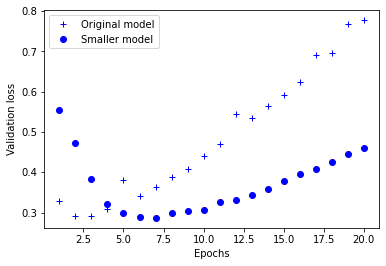

In [32]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [33]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [34]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 18s 738us/step - loss: 0.4465 - acc: 0.8006 - val_loss: 0.2816 - val_acc: 0.8889
Epoch 2/20
25000/25000 [==============================] - 16s 634us/step - loss: 0.2086 - acc: 0.9188 - val_loss: 0.3050 - val_acc: 0.8810
Epoch 3/20
25000/25000 [==============================] - 15s 592us/step - loss: 0.1185 - acc: 0.9602 - val_loss: 0.5612 - val_acc: 0.8266
Epoch 4/20
25000/25000 [==============================] - 17s 666us/step - loss: 0.0645 - acc: 0.9813 - val_loss: 0.4652 - val_acc: 0.8819
Epoch 5/20
25000/25000 [==============================] - 22s 875us/step - loss: 0.0864 - acc: 0.9884 - val_loss: 0.5099 - val_acc: 0.8789
Epoch 6/20
25000/25000 [==============================] - 22s 883us/step - loss: 0.0059 - acc: 0.9985 - val_loss: 5.4485 - val_acc: 0.5818
Epoch 7/20
25000/25000 [==============================] - 23s 905us/step - loss: 0.0902 - acc: 0.9906 - val_loss: 0.

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

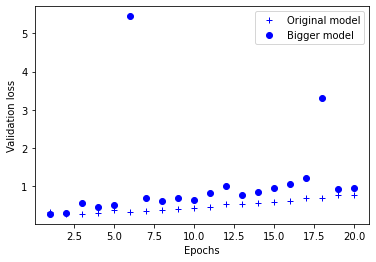

In [35]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

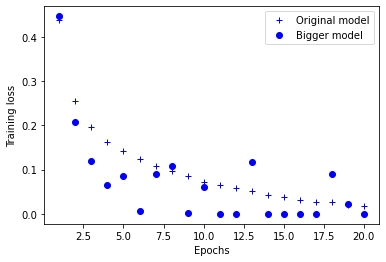

In [36]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight 
regularization to our movie review classification network:

In [37]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2 regularization penalty:

In [39]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 133us/step - loss: 0.4922 - acc: 0.8204 - val_loss: 0.4052 - val_acc: 0.8552
Epoch 2/20
25000/25000 [==============================] - 3s 132us/step - loss: 0.3114 - acc: 0.9070 - val_loss: 0.3622 - val_acc: 0.8710
Epoch 3/20
25000/25000 [==============================] - 4s 159us/step - loss: 0.2704 - acc: 0.9198 - val_loss: 0.3340 - val_acc: 0.8861
Epoch 4/20
25000/25000 [==============================] - 4s 175us/step - loss: 0.2483 - acc: 0.9277 - val_loss: 0.3313 - val_acc: 0.8880
Epoch 5/20
25000/25000 [==============================] - 5s 180us/step - loss: 0.2354 - acc: 0.9351 - val_loss: 0.3398 - val_acc: 0.8836
Epoch 6/20
25000/25000 [==============================] - 5s 182us/step - loss: 0.2299 - acc: 0.9360 - val_loss: 0.3690 - val_acc: 0.8749
Epoch 7/20
25000/25000 [==============================] - 5s 202us/step - loss: 0.2225 - acc: 0.9385 - val_loss: 0.3525 - 

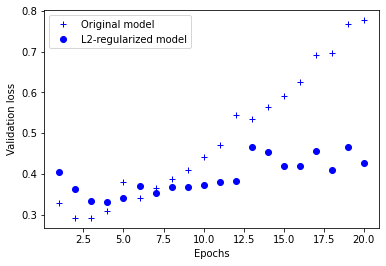

In [40]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), 
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [41]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be 
zero-ing out at random a fraction of the values in the matrix:

In [ ]:
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)


At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the 
units):

In [ ]:
# At test time:
layer_output *= 0.5


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is 
often the way it is implemented in practice:

In [ ]:
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
model.add(layers.Dropout(0.5))

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [43]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [44]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 166us/step - loss: 0.6044 - acc: 0.6854 - val_loss: 0.5050 - val_acc: 0.8606
Epoch 2/20
25000/25000 [==============================] - 3s 126us/step - loss: 0.4775 - acc: 0.8091 - val_loss: 0.3988 - val_acc: 0.8772
Epoch 3/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.3982 - acc: 0.8637 - val_loss: 0.3443 - val_acc: 0.8838
Epoch 4/20
25000/25000 [==============================] - 3s 140us/step - loss: 0.3412 - acc: 0.8886 - val_loss: 0.3146 - val_acc: 0.8827
Epoch 5/20
25000/25000 [==============================] - 3s 139us/step - loss: 0.2970 - acc: 0.9052 - val_loss: 0.3025 - val_acc: 0.8833
Epoch 6/20
25000/25000 [==============================] - 3s 139us/step - loss: 0.2648 - acc: 0.9171 - val_loss: 0.3027 - val_acc: 0.8845
Epoch 7/20
25000/25000 [==============================] - 3s 137us/step - loss: 0.2344 - acc: 0.9258 - val_loss: 0.3082 - 

Let's plot the results:

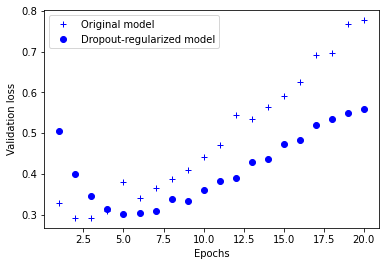

In [45]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.

# In-class Exercise: Real-bogus classification for the Zwicky Transient Facility (ZTF) using deep learning

## Efficient automated detection of flux-transient, reoccurring flux-variable, and moving objects is increasingly important for large-scale astronomical surveys.

* Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

<img src='img/fig-ztf_alerts.png'>

* The real/bogus ($rb$) machine learning (ML) classifiers are designed to separate genuine astrophysical events from bogus detections by scoring individual sources on a scale from 0.0 (bogus) to 1.0 (real). Currently, ZTF employs two $rb$ classifiers: a feature-based random forest classifier ($rfrb$), and `braai` a convolutional-neural-network, deep-learning classifier.
* In this tutorial, we will build a deep $rb$ classifier based on `braai`. We will use a data set consisting of $11.5k$ labeled alerts from the [ZTF public alert stream](https://ztf.uw.edu/alerts/public/).
* For further details on `braai` please refer to For details, please see [Duev+ 2019, MNRAS, 489, 3582](https://academic.oup.com/mnras/article/489/3/3582/5554758) or [arXiv:1907.11259](https://arxiv.org/pdf/1907.11259.pdf).

### Imports

In [1]:
from IPython.display import HTML, display
import tqdm
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import datetime
from astropy.time import Time

import os
import io
import gzip
from astropy.io import fits
# pip install pymongo
from bson.json_util import loads, dumps

import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters, scatter_matrix
register_matplotlib_converters()
%matplotlib inline

### Data set

Download from `skipper` if necessary:

In [2]:
!wget -O candidates.csv https://storage.googleapis.com/dmitryduev/braai.candidates.programid1.csv
!wget -O triplets.norm.npy https://storage.googleapis.com/dmitryduev/braai.triplets.norm.programid1.npy
!ls

--2021-04-19 16:14:41--  https://storage.googleapis.com/dmitryduev/braai.candidates.programid1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.192.176, 142.250.191.176, 172.217.9.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.192.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16585888 (16M) [application/octet-stream]
Saving to: ‘candidates.csv’

candidates.csv      100%[===================>]  15.82M  8.53MB/s    in 1.9s    

2021-04-19 16:14:43 (8.53 MB/s) - ‘candidates.csv’ saved [16585888/16585888]

--2021-04-19 16:14:43--  https://storage.googleapis.com/dmitryduev/braai.triplets.norm.programid1.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.80, 142.250.190.48, 216.58.192.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100778464 (1.0G) [application/octet-stream]
S

#### Candidates

First load the $csv$ file containing the `candidate` block of the alerts (cutouts and previous detections are excluded). All alerts are labeled (0=bogus, 1=real).

In [4]:
df = pd.read_csv('candidates.csv')
display(df)
df.info()
df.describe()

,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
0,0,1.051,0.308211,0.991,0.290616,737414800515015021,3.024,1.074084,0.953,0.090182,...,19.752300,18.349100,19.709101,21,0,1102.627808,2502.003174,-0.000003,26.278999,1
1,1,0.911,0.283801,0.877,0.273209,548211733715015007,0.895,1.868645,0.921,NaN,...,18.470301,20.777000,20.725700,7,0,2904.806396,280.736298,NaN,NaN,1
2,2,0.802,0.586078,0.669,0.488886,527282584015015018,2.373,1.259607,0.876,NaN,...,17.358500,-999.000000,-999.000000,18,0,1045.247070,2085.618652,NaN,NaN,1
3,3,0.708,0.534324,0.673,0.507909,540383446315015002,0.217,5.922930,0.992,NaN,...,14.093500,19.026699,20.882000,2,0,279.002289,381.362091,NaN,NaN,1
4,4,0.927,0.317466,0.881,0.301712,806286202415015004,3.389,3.200528,0.983,-0.080435,...,20.331200,20.488501,-999.000000,4,0,1296.672852,861.606018,-0.000052,26.166000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11551,11551,1.833,0.385895,1.189,0.250316,739458591615010002,0.721,7.560311,0.977,0.096468,...,21.166901,-999.000000,20.226500,2,0,77.071404,2386.187988,-0.000008,26.271000,0
11552,11552,0.543,0.316860,0.407,0.237499,757172973715015018,1.217,110.132088,0.996,-0.027756,...,11.218000,-999.000000,15.170200,18,0,2392.119385,1160.997314,-0.000008,26.139000,0
11553,11553,0.786,0.241104,0.687,0.210736,760143561415015025,3.879,3.974642,0.950,0.077196,...,18.407200,19.270201,12.458000,25,0,2683.692627,623.401001,-0.000005,26.049999,0
11554,11554,1.448,0.218401,1.078,0.162594,786157411215015113,0.579,6.098668,0.110,-0.078874,...,19.115700,11.614000,14.894300,113,0,1652.860962,2199.916748,-0.000017,26.172001,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11556 entries, 0 to 11555
Columns: 103 entries, Unnamed: 0 to label
dtypes: float64(79), int64(19), object(5)
memory usage: 9.1+ MB


,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
count,11556.00000,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04,11556.000000,11556.000000,11556.000000,8448.000000,...,11556.000000,11556.000000,11556.000000,11556.000000,11556.0,11556.000000,11556.000000,8448.000000,8448.000000,11556.000000
mean,5777.50000,1.073267,-8.026193,0.895498,-8.076731,6.393815e+17,-22.500750,17.101113,0.860534,0.027765,...,-141.066174,-237.406817,-260.553024,24.679387,0.0,1562.592689,1563.468948,-0.000087,26.162647,0.691589
std,3336.07419,0.888390,91.182468,0.676887,91.176462,1.074571e+17,156.702592,95.183081,0.232018,0.088743,...,368.660709,441.456463,454.140601,45.581802,0.0,891.664377,872.083664,0.002138,0.280054,0.461857
min,0.00000,0.289000,-999.000000,0.254000,-999.000000,4.444618e+17,-999.000000,0.145480,0.000000,-0.791248,...,-999.000000,-999.000000,-999.000000,0.000000,0.0,11.030300,10.019900,-0.127653,21.896999,0.000000
25%,2888.75000,0.731000,0.268761,0.654000,0.232750,5.404585e+17,0.733000,1.450537,0.841000,-0.051204,...,12.753225,-999.000000,-999.000000,4.000000,0.0,787.948593,809.693359,-0.000017,26.132000,0.000000
50%,5777.50000,0.838000,0.320363,0.752000,0.287891,6.714277e+17,1.416000,2.603290,0.974000,0.073595,...,17.182651,18.185300,18.388551,11.000000,0.0,1562.246704,1591.725708,-0.000008,26.218000,1.000000
75%,8666.25000,1.075000,0.380548,0.923000,0.337443,7.182429e+17,3.944000,7.096814,0.983000,0.097531,...,19.207199,20.155224,20.324699,25.000000,0.0,2331.450623,2338.382385,-0.000004,26.280001,1.000000
max,11555.00000,23.407000,55.650002,15.154000,47.450001,8.652526e+17,121.080002,7037.184570,1.000000,2.095540,...,22.355900,23.205200,22.111300,871.000000,0.0,3062.439697,3070.481934,-0.000001,26.827999,1.000000


In [5]:
print(f'num_bogus: {np.sum(df.label == 0)}')
print(f'num_real: {np.sum(df.label == 1)}')

num_bogus: 3564
num_real: 7992


#### Cutout images

In [6]:
def make_triplet(alert, normalize: bool = False, to_tpu: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            # print(f'Shape of {candid}/{cutout}: {shape}, padding to (63, 63)')
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']
    
    if to_tpu:
        # Edge TPUs require additional processing
        triplet = np.rint(triplet * 128 + 128).astype(np.uint8).flatten()
    
    return triplet

We will now load pre-processed image cutout triplets: [epochal science image, reference image, ZOGY difference image]. The ZTF cutout images are centered on the event candidate and are of size 63x63 pixels (or smaller, if the event is detected near the CCD edge) at a plate scale of 1$"$ per pixel. We perform independent $L^2$-normalization of the epochal science, reference, and difference cutouts and stack them to form 63x63x3 triplets that are input into the model. Smaller examples are accordingly padded using a constant pixel value of $10^{-9}$. See function `make_triplet` above.

In [8]:
# We will use memory mapping as the file is relatively large (1 GB)
triplets = np.load('triplets.norm.npy', mmap_mode='r')

#### Visuals

Plot a few triplet examples:

candid: 751519215515015005, label: 1


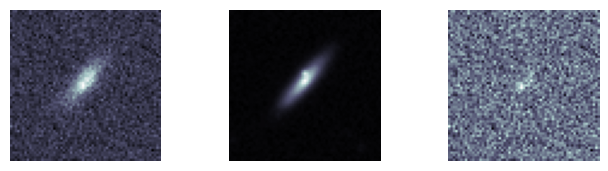

candid: 726498690615015025, label: 1


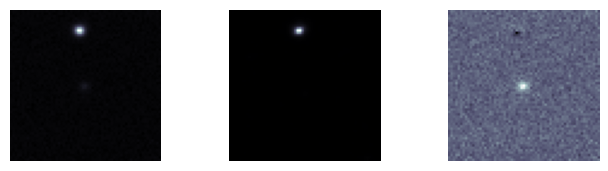

candid: 592385823315015047, label: 1


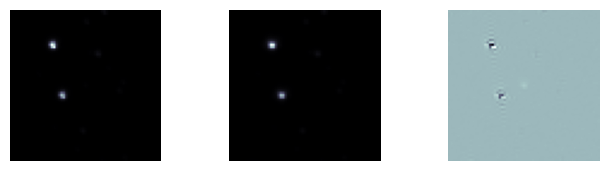

candid: 674496006015015073, label: 1


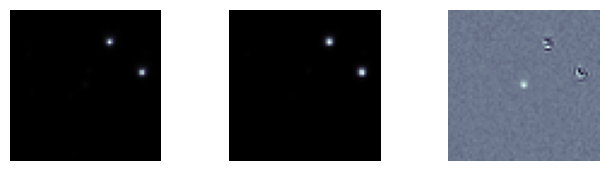

candid: 469170121115015038, label: 0


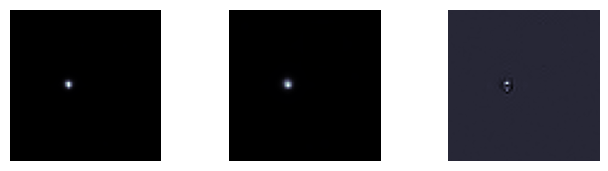

In [9]:
ind = np.random.randint(0, high=len(df), size=5)
for ii in ind:
    print(f'candid: {df.loc[ii, "candid"]}, label: {df.loc[ii, "label"]}')
    fig = plt.figure(figsize=(8, 2), dpi=100)
    triplet = triplets[ii, :]
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(triplet[:, :, 0], origin='lower', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(triplet[:, :, 1], origin='lower', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(triplet[:, :, 2], origin='lower', cmap=plt.cm.bone)
    plt.show()

Let's explore the dataset a little bit:

<ipython-input-10-0b716832983a>:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axx = scatter_matrix(df.loc[df.label >= 0, columns],


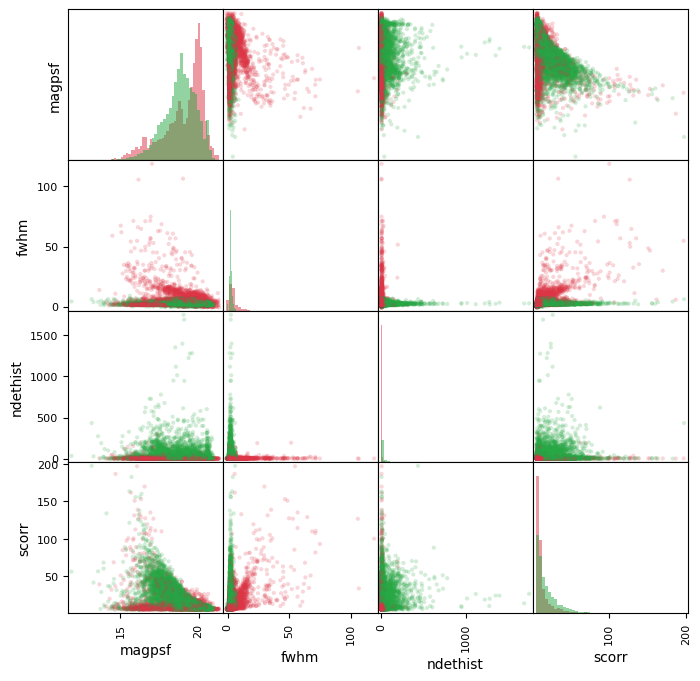

In [10]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)

color_wheel = {0: "#dc3545", 
               1: "#28a745"}
colors = df["label"].map(lambda x: color_wheel.get(x))

columns = ['magpsf', 'fwhm', 'ndethist', 'scorr']

axx = scatter_matrix(df.loc[df.label >= 0, columns], 
                     alpha=0.2,  diagonal='hist', ax=ax, grid=True, color=colors,
                     hist_kwds={'color': 'darkblue', 'alpha': 0, 'bins': 50})

for rc in range(len(columns)):
    rc_y_max = 0
    for group in color_wheel.keys():
        y = df[df.label == group][columns[rc]]
        hh = axx[rc][rc].hist(y, bins=50, alpha=0.5, color=color_wheel[group], density=1)
#         print(np.min(hh[0]), np.max(hh[0]))
        rc_y_max = max(rc_y_max, np.max(hh[0]))
        axx[rc][rc].set_ylim([0, 1.1*rc_y_max])

# scatter_matrix(df.loc[df.label == 0, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#dc3545', 'alpha': 0.5, 'bins': 100}, color='#dc3545')
# scatter_matrix(df.loc[df.label == 1, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#28a745', 'alpha': 0.5, 'bins': 100}, color='#28a745')

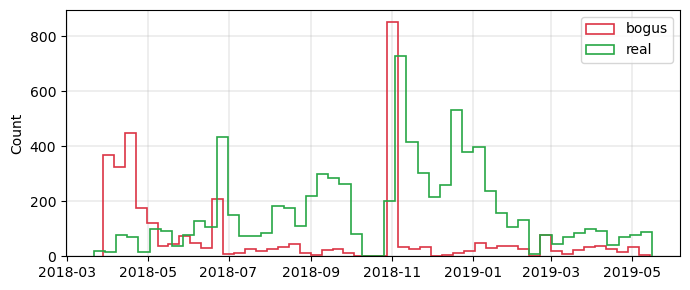

In [11]:
df['date'] = df['jd'].map(lambda x: Time(x, format='jd').datetime)
fig = plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(111)
ax.hist(df.loc[df['label'] == 0, 'date'], bins=50, #linestyle='dashed',
        color=color_wheel[0], histtype='step', label='bogus', linewidth=1.2)
ax.hist(df.loc[df['label'] == 1, 'date'], bins=50,
        color=color_wheel[1], histtype='step', label='real', linewidth=1.2)
# ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.grid(True, linewidth=.3)
plt.tight_layout()

We will use 81\% / 9\% / 10\% training/validation/test data split:

In [12]:
test_split = 0.1

# set random seed for reproducable results:
random_state = 42

x_train, x_test, y_train, y_test = train_test_split(triplets, df.label, 
                                                    test_size=test_split, random_state=random_state)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(10400, 63, 63, 3) (1156, 63, 63, 3) (10400,) (1156,)


### `braai` architecture

We will use a simple custom VGG-like sequential model ($VGG6$; this architecture was first proposed by the Visual Geometry Group of the Department of Engineering Science, University of Oxford, UK). The model has six layers with trainable parameters: four convolutional and two fully-connected. The first two convolutional layers use 16 3x3 pixel filters each while in the second pair, 32 3x3 pixel filters are used. To prevent over-fitting, a dropout rate of 0.25 is applied after each max-pooling layer and a dropout rate of 0.5 is applied after the second fully-connected layer. ReLU activation functions (Rectified Linear Unit --  a function defined as the positive part of its argument) are used for all five hidden trainable layers; a sigmoid activation function is used for the output layer.

![](img/fig-braai2.png)

In [13]:
def vgg6(input_shape=(63, 63, 3), n_classes: int = 1):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 63x63 images with 3 channel -> (63, 63, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### Model training

`braai` is implemented using `TensorFlow` software and its high-level `Keras` API. We will use the binary cross-entropy loss function, the Adam optimizer, a batch size of 64, and a 81\%/9\%/10\% training/validation/test data split. The training image data are weighted per class to mitigate the real vs. bogus imbalance in the data sets. To augment the data, the images may be flipped horizontally and/or vertically at random. No random rotations and translations will be added.

In [14]:
def save_report(path: str = './', stamp: str = None, report: dict = dict()):
    f_name = os.path.join(path, f'report.{stamp}.json')
    with open(f_name, 'w') as f:
        json.dump(report, f, indent=2)

# make train and test masks:
_, _, mask_train, mask_test = train_test_split(df.label, list(range(len(df.label))),
                                                   test_size=test_split, random_state=random_state)
masks = {'training': mask_train, 'test': mask_test}

In [15]:
tf.keras.backend.clear_session()

loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 100
patience = 50
# epochs = 10
# patience = 5
validation_split = 0.1
class_weight = True
batch_size = 64

# halt training if no gain in validation accuracy over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

data_augmentation = {'horizontal_flip': True,
                     'vertical_flip': True,
                     'rotation_range': 0,
                     'fill_mode': 'constant',
                     'cval': 1e-9}
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=data_augmentation['horizontal_flip'],
                                                          vertical_flip=data_augmentation['vertical_flip'],
                                                          rotation_range=data_augmentation['rotation_range'],
                                                          fill_mode=data_augmentation['fill_mode'],
                                                          cval=data_augmentation['cval'],
                                                          validation_split=validation_split)

training_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation')

In [16]:
binary_classification = True if loss == 'binary_crossentropy' else False
n_classes = 1 if binary_classification else 2

# training data weights
if class_weight:
    # weight data class depending on number of examples?
    if not binary_classification:
        num_training_examples_per_class = np.sum(y_train, axis=0)
    else:
        num_training_examples_per_class = np.array([len(y_train) - np.sum(y_train), np.sum(y_train)])

    assert 0 not in num_training_examples_per_class, 'found class without any examples!'

    # fewer examples -- larger weight
    weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
    normalized_weight = weights / np.max(weights)

    class_weight = {i: w for i, w in enumerate(normalized_weight)}

else:
    class_weight = {i: 1 for i in range(2)}
    
# image shape:
image_shape = x_train.shape[1:]
print('Input image shape:', image_shape)

Input image shape: (63, 63, 3)


Build and compile the model:

In [17]:
model = vgg6(input_shape=image_shape, n_classes=n_classes)

# set up optimizer:
if optimizer == 'adam':
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)
elif optimizer == 'sgd':
    optimzr = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
else:
    print('Could not recognize optimizer, using Adam')
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimzr, loss=loss, metrics=['accuracy'])

print(model.summary())

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0      

Train!

In [18]:
run_t_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'braai_{model.name}_{run_t_stamp}'

h = model.fit_generator(training_generator,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=validation_generator,
                        validation_steps=(len(x_train)*validation_split) // batch_size,
                        class_weight=class_weight,
                        epochs=epochs,
                        verbose=1, callbacks=[early_stopping])

/home/andrea/anaconda3/envs/astro/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
162/162 [==============================] - 22s 129ms/step - loss: 15.6755 - accuracy: 0.5676 - val_loss: 1.3178 - val_accuracy: 0.8535


### Model evaluation

Let's now evaluate the resulting model:

In [19]:
print('Evaluating on training set to check misclassified samples:')
labels_training_pred = model.predict(x_train, batch_size=batch_size, verbose=1)
# XOR will show misclassified samples
misclassified_train_mask = np.array(list(map(int, df.label[masks['training']]))).flatten() ^ \
                           np.array(list(map(int, np.rint(labels_training_pred)))).flatten()
misclassified_train_mask = [ii for ii, mi in enumerate(misclassified_train_mask) if mi == 1]

misclassifications_train = {int(c): [int(l), float(p)]
                            for c, l, p in zip(df.candid.values[masks['training']][misclassified_train_mask],
                                               df.label.values[masks['training']][misclassified_train_mask],
                                               labels_training_pred[misclassified_train_mask])}
# print(misclassifications_train)

print('Evaluating on test set for loss and accuracy:')
preds = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
test_loss = float(preds[0])
test_accuracy = float(preds[1])
print("Loss = " + str(test_loss))
print("Test Accuracy = " + str(test_accuracy))

print('Evaluating on training set to check misclassified samples:')
preds = model.predict(x=x_test, batch_size=batch_size, verbose=1)

# XOR will show misclassified samples
misclassified_test_mask = np.array(list(map(int, df.label[masks['test']]))).flatten() ^ \
                          np.array(list(map(int, np.rint(preds)))).flatten()
misclassified_test_mask = [ii for ii, mi in enumerate(misclassified_test_mask) if mi == 1]

misclassifications_test = {int(c): [int(l), float(p)]
                           for c, l, p in zip(df.candid.values[masks['test']][misclassified_test_mask],
                                              df.label.values[masks['test']][misclassified_test_mask],
                                              preds[misclassified_test_mask])}

# round probs to nearest int (0 or 1)
labels_pred = np.rint(preds)

Evaluating on training set to check misclassified samples:
163/163 [==============================] - 5s 28ms/step
Evaluating on test set for loss and accuracy:
19/19 [==============================] - 1s 25ms/step - loss: 1.7097 - accuracy: 0.8244
Loss = 1.7096891403198242
Test Accuracy = 0.8243944644927979
Evaluating on training set to check misclassified samples:
19/19 [==============================] - 1s 25ms/step


#### Plot accuracy vs. epoch and Loss vs. epoch

In [20]:
# YOUR CODE HERE
plt.plot(np.arange(test_loss), test_loss)

AttributeError: 'float' object has no attribute 'shape'

#### Plot confusion matrices with score threshold=0.5

In [18]:
# YOUR CODE HERE

#### Plot False Negative Rate vs False Positive Rate

In [3]:
# YOUR CODE HERE

#### Plot ROC curve

In [4]:
# YOUR CODE HERE

#### Generate report

In [ ]:
# generate training report in json format
print('Generating report...')
r = {'Run time stamp': run_t_stamp,
     'Model name': model_name,
     'Model trained': 'vgg6',
     'Batch size': batch_size,
     'Optimizer': optimizer,
     'Requested number of train epochs': epochs,
     'Early stopping after epochs': patience,
     'Training+validation/test split': test_split,
     'Training/validation split': validation_split,
     'Weight training data by class': class_weight,
     'Random state': random_state,
     'Number of training examples': x_train.shape[0],
     'Number of test examples': x_test.shape[0],
     'X_train shape': x_train.shape,
     'Y_train shape': y_train.shape,
     'X_test shape': x_test.shape,
     'Y_test shape': y_test.shape,
     'Data augmentation': data_augmentation,
     'Test loss': test_loss,
     'Test accuracy': test_accuracy,
     'Confusion matrix': confusion_matr.tolist(),
     'Normalized confusion matrix': confusion_matr_normalized.tolist(),
     'Misclassified test candids': list(misclassifications_test.keys()),
     'Misclassified training candids': list(misclassifications_train.keys()),
     'Test misclassifications': misclassifications_test,
     'Training misclassifications': misclassifications_train,
     'Training history': h.history
     }
for k in r['Training history'].keys():
    r['Training history'][k] = np.array(r['Training history'][k]).tolist()

# print(r)

save_report(path='./', stamp=run_t_stamp, report=r)
print('Done.')

### Some real data

In [23]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=100)
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    plt.show()

In [24]:
#!wget -O 714287740515015072.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/714287740515015072.json
#!wget -O 893215910715010007.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/893215910715010007.json

In [ ]:
with open('714287740515015072.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))

In [ ]:
with open('893215910715010007.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))